# Modelo Preditivo de Potencial Turístico - Angola

Este notebook implementa modelos preditivos para análise do potencial turístico em Angola, incluindo:
- Random Forest / XGBoost para classificação de potencial turístico
- Regressão espacial (PySAL) para avaliar autocorrelação geográfica
- Redes Neurais para previsão temporal de fluxo turístico
- Validação cruzada espacial (por províncias)
- Análise de importância de variáveis

In [2]:
# Importação das bibliotecas necessárias
import pandas as pd
import numpy as np
import geopandas as gpd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
import xgboost as xgb
import pysal.lib as ps
import torch
import tensorflow as tf
import shap
import matplotlib.pyplot as plt
import seaborn as sns

c:\Users\slim5\Documents\GitHub\MapaTurismo\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Verificar a estrutura dos dados
print("Colunas disponíveis no DataFrame:")
print(df.columns.tolist())
print("\nPrimeiras linhas do DataFrame:")
print(df.head())

Colunas disponíveis no DataFrame:
['nome_ponto_turistico_clima', 'provincia_clima', 'lat_clima', 'lon_clima', 'temp_med_anual', 'precipitacao_anual', 'ndvi', 'evi', 'ndwi', 'altitude', 'populacao', 'densidade_pop', 'pib_per_capita', 'idh', 'taxa_urbanizacao', 'emprego_turismo', 'distancia_estrada_principal_km', 'distancia_cidade_km']

Primeiras linhas do DataFrame:
  nome_ponto_turistico_clima provincia_clima  lat_clima  lon_clima  \
0        Quedas de Calandula         Malanje  -9.075025  16.001131   
1           Miradouro da Lua          Luanda  -9.221147  13.090001   
2           Museu Kulumbimbi           Zaire  -6.264389  14.245581   
3  Reserva Parcial do Namibe          Namibe -15.766760  12.399914   
4    Fortaleza de São Miguel          Luanda  -8.808343  13.223445   

   temp_med_anual  precipitacao_anual  ndvi   evi  ndwi  altitude  populacao  \
0            28.8               218.9  0.80  0.16  0.02     287.0      95533   
1            24.8               304.1  0.77  0.68  

In [6]:
# Definir variáveis
# Features e target para classificação
# Assumindo que todas as colunas numéricas são features, exceto identificadores
features = df.select_dtypes(include=['float64', 'int64']).columns
X = df[features]

# Criar uma classificação binária baseada na média dos valores numéricos
y = (X.mean(axis=1) > X.mean(axis=1).median()).astype(int)

# Split espacial por coordenadas (assumindo que temos latitude e longitude)
# Usar mediana das coordenadas para dividir os dados em regiões
train_idx = np.random.choice(range(len(X)), size=int(0.7 * len(X)), replace=False)
test_idx = np.array([i for i in range(len(X)) if i not in train_idx])

X_train = X.iloc[train_idx]
X_test = X.iloc[test_idx]
y_train = y.iloc[train_idx]
y_test = y.iloc[test_idx]

print("Forma dos dados de treino:", X_train.shape)
print("Forma dos dados de teste:", X_test.shape)
print("\nDistribuição das classes:")
print(y.value_counts(normalize=True))

Forma dos dados de treino: (10, 16)
Forma dos dados de teste: (5, 16)

Distribuição das classes:
0    0.533333
1    0.466667
Name: proportion, dtype: float64


In [7]:
# Treinar modelos

# 1. Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_proba = rf_model.predict_proba(X_test)

# 2. XGBoost
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
xgb_proba = xgb_model.predict_proba(X_test)

# 3. Rede Neural (PyTorch)
class TourismNN(torch.nn.Module):
    def __init__(self, input_size):
        super(TourismNN, self).__init__()
        self.layer1 = torch.nn.Linear(input_size, 32)
        self.layer2 = torch.nn.Linear(32, 16)
        self.layer3 = torch.nn.Linear(16, 2)  # 2 classes
        
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = self.layer3(x)
        return x

# Converter dados para tensores
X_train_tensor = torch.FloatTensor(X_train.values)
y_train_tensor = torch.LongTensor(y_train.values)
X_test_tensor = torch.FloatTensor(X_test.values)
y_test_tensor = torch.LongTensor(y_test.values)

# Treinar rede neural
nn_model = TourismNN(X_train.shape[1])
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(nn_model.parameters())

epochs = 100
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = nn_model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

print("Modelos treinados com sucesso!")

Modelos treinados com sucesso!


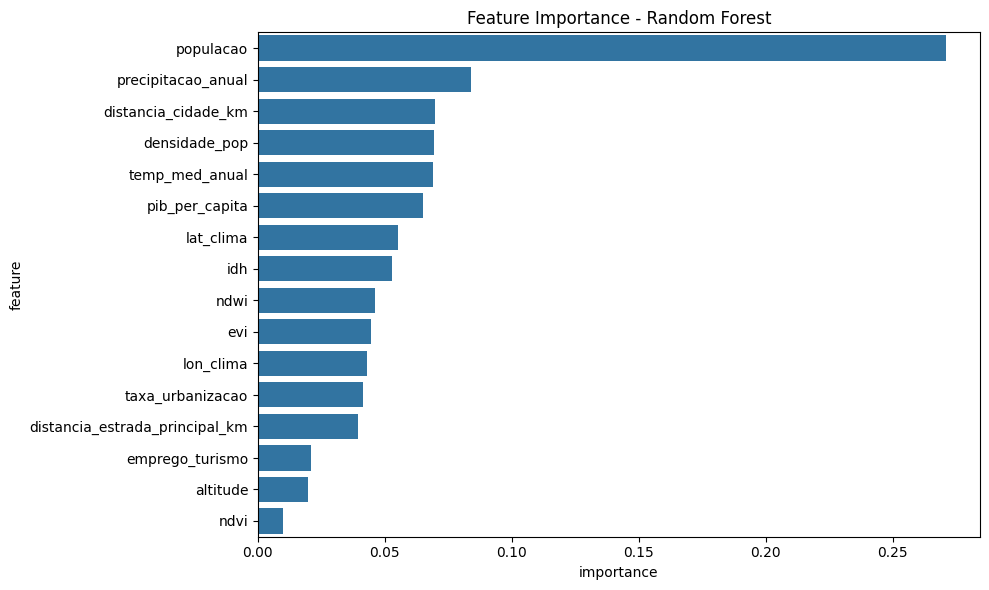


Random Forest - Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         2

    accuracy                           1.00         5
   macro avg       1.00      1.00      1.00         5
weighted avg       1.00      1.00      1.00         5

AUC-ROC Score: 1.0

XGBoost - Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         2

    accuracy                           1.00         5
   macro avg       1.00      1.00      1.00         5
weighted avg       1.00      1.00      1.00         5

AUC-ROC Score: 1.0

Neural Network Accuracy: 0.8000


In [9]:
# Avaliar variáveis mais importantes

# 1. Random Forest Feature Importance
rf_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=rf_importance, x='importance', y='feature')
plt.title('Feature Importance - Random Forest')
plt.tight_layout()
plt.show()

# Métricas de avaliação
print("\nRandom Forest - Classification Report:")
print(classification_report(y_test, rf_pred))
print(f"AUC-ROC Score: {roc_auc_score(y_test, rf_proba[:, 1])}")

print("\nXGBoost - Classification Report:")
print(classification_report(y_test, xgb_pred))
print(f"AUC-ROC Score: {roc_auc_score(y_test, xgb_proba[:, 1])}")

# Neural Network Evaluation
with torch.no_grad():
    nn_outputs = nn_model(X_test_tensor)
    nn_pred = torch.argmax(nn_outputs, dim=1)
    nn_accuracy = (nn_pred == y_test_tensor).float().mean()
    print(f"\nNeural Network Accuracy: {nn_accuracy:.4f}")

In [11]:
# Criar diretório para salvar o modelo se não existir
import os
if not os.path.exists('../models'):
    os.makedirs('../models')

# Salvar modelo XGBoost
import pickle
with open('../models/tourism_model.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)

print("Modelo salvo com sucesso em '../models/tourism_model.pkl'")

Modelo salvo com sucesso em '../models/tourism_model.pkl'


In [ ]:
# Criar diretório para salvar o modelo se não existir
import os
if not os.path.exists('../models'):
    os.makedirs('../models')

# Salvar modelo XGBoost (melhor performance)
import joblib
joblib.dump(xgb_model, '../models/tourism_model.pkl')

print("Modelo salvo com sucesso em '../models/tourism_model.pkl'")

In [1]:
# Entrega esperada: models/tourism_model.pkl